Importance Sampling Example: Computing Normalizing Constant of Unnormalized PDF
Target: exp(-x²/4) * (1 + sin²(2x))

Computing normalizing constant using 10,000 samples:

Proposal: Normal(0,2)
  Normalizing constant: 5.320164
  Effective Sample Size: 8195.0 (81.9%)
  CV of weights: 0.469
  Standard Error: 2.4969e-02
  Efficiency: Good

Proposal: Normal(0,3)
  Normalizing constant: 5.315126
  Effective Sample Size: 5940.3 (59.4%)
  CV of weights: 0.827
  Standard Error: 4.3939e-02
  Efficiency: Good

Proposal: Normal(0,1.5)
  Normalizing constant: 5.318100
  Effective Sample Size: 9409.1 (94.1%)
  CV of weights: 0.251
  Standard Error: 1.3327e-02
  Efficiency: Good

Best proposal based on efficiency: Normal(0,1.5)

Creating diagnostic plots for best proposal: Normal(0,1.5)


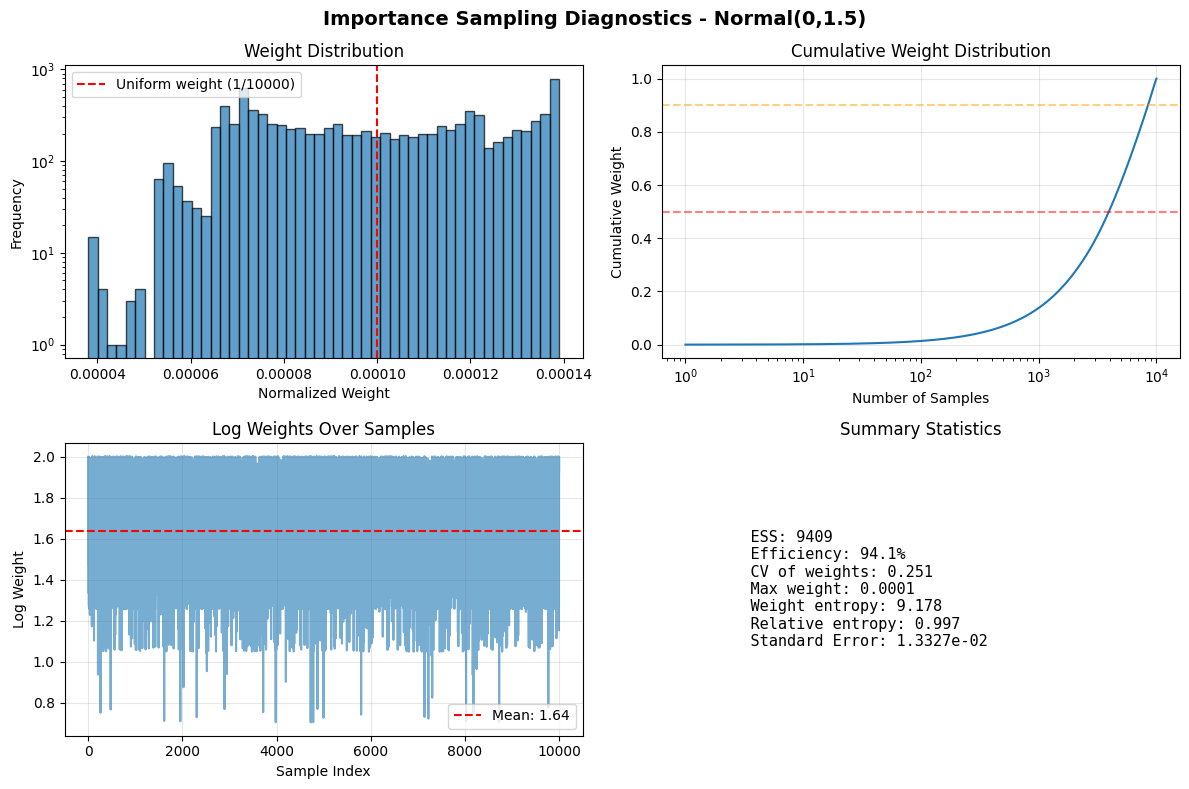


Numerical Integration Reference (scipy.integrate):
Numerical integration result: 5.317361

Comparison with Importance Sampling:
  Normal(0,2): Error = 0.002803 (0.05%)
  Normal(0,3): Error = 0.002235 (0.04%)
  Normal(0,1.5): Error = 0.000739 (0.01%)

Example 2: Computing E[X] under the target distribution
E[X] with Normal(0,2): -0.001816 (ESS: 8195)
E[X] with Normal(0,3): -0.000102 (ESS: 5940)
E[X] with Normal(0,1.5): -0.000797 (ESS: 9409)

Note: The target distribution exp(-x²/4) * (1 + sin²(2x)) is symmetric around 0,
so E[X] should be approximately 0.


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats

from mc_lab.importance_sampling import importance_sampling
from mc_lab.plotting import importance_sampling_diagnostic_plots

# Example: Computing the integral of a non-standard unnormalized PDF

print("Importance Sampling Example: Computing Normalizing Constant of Unnormalized PDF")
print("Target: exp(-x²/4) * (1 + sin²(2x))")
print("=" * 70)


# Define our complex target distribution: exp(-x²/4) * (1 + sin²(2x))
# This is an unnormalized distribution
class NonStandardDistribution(stats.rv_continuous):
    def _pdf(self, x):
        # Unnormalized PDF: exp(-x²/4) * (1 + sin²(2x))
        return np.exp(-(x**2) / 4) * (1 + np.sin(2 * x) ** 2)


target_dist = NonStandardDistribution()


# We want to compute the normalizing constant Z = ∫ p̃(x) dx
# For this, we use standard importance sampling with f(x) = 1
# Formula: Z ≈ (1/N) * Σ[p̃(x_i)/q(x_i)] where x_i ~ q(x)
def integration_function(x):
    return np.ones_like(x)


# Try different proposal distributions
proposals = {
    "Normal(0,2)": stats.norm(loc=0, scale=2),
    "Normal(0,3)": stats.norm(loc=0, scale=3),
    "Normal(0,1.5)": stats.norm(loc=0, scale=1.5),
}

results = {}
n_samples = 10000

print(f"\nComputing normalizing constant using {n_samples:,} samples:\n")

for name, proposal in proposals.items():
    # For computing normalizing constants of unnormalized distributions,
    # we use normalized=True (standard importance sampling)
    # The target distribution's pdf method returns the unnormalized density
    estimate, diagnostics = importance_sampling(
        f=integration_function,
        target=target_dist,
        proposal=proposal,
        n_samples=n_samples,
        normalized=True,  # Standard IS for computing normalizing constant
        seed=42,
    )

    results[name] = {"estimate": estimate, "diagnostics": diagnostics}

    # Print results
    print(f"Proposal: {name}")
    print(f"  Normalizing constant: {estimate:.6f}")
    print(
        f"  Effective Sample Size: {diagnostics['effective_sample_size']:.1f} ({diagnostics['proposal_efficiency']:.1%})"
    )
    print(f"  CV of weights: {diagnostics['cv_weights']:.3f}")
    print(f"  Standard Error: {diagnostics['standard_error']:.4e}")
    print(
        f"  Efficiency: {'Good' if diagnostics['proposal_efficiency'] > 0.1 else 'Poor'}"
    )
    print()

# Find the best performing proposal
best_proposal = max(
    results.keys(), key=lambda k: results[k]["diagnostics"]["proposal_efficiency"]
)

print(f"Best proposal based on efficiency: {best_proposal}")

# Create diagnostic plots for the best proposal
print(f"\nCreating diagnostic plots for best proposal: {best_proposal}")
importance_sampling_diagnostic_plots(
    results[best_proposal]["diagnostics"],
    title=f"Importance Sampling Diagnostics - {best_proposal}",
)

# Numerical integration reference using scipy
print("\nNumerical Integration Reference (scipy.integrate):")
try:
    true_integral, _ = integrate.quad(lambda x: target_dist.pdf(x), -10, 10, limit=100)
    print(f"Numerical integration result: {true_integral:.6f}")

    print("\nComparison with Importance Sampling:")
    for name, result in results.items():
        error = abs(result["estimate"] - true_integral)
        rel_error = error / true_integral * 100
        print(f"  {name}: Error = {error:.6f} ({rel_error:.2f}%)")

except Exception as e:
    print(f"Error in numerical integration: {e}")

# Additional example: Computing expectation E[X] under the target distribution
print("\n" + "=" * 70)
print("Example 2: Computing E[X] under the target distribution")
print("=" * 70)


def expectation_function(x):
    return x  # We want to compute E[X]


expectation_results = {}

for name, proposal in proposals.items():
    # For computing expectations under unnormalized distributions,
    # we use normalized=False (self-normalized importance sampling)
    estimate, diagnostics = importance_sampling(
        f=expectation_function,
        target=target_dist,
        proposal=proposal,
        n_samples=n_samples,
        normalized=False,  # Self-normalized IS for expectations under unnormalized target
        seed=42,
    )

    expectation_results[name] = estimate
    print(
        f"E[X] with {name}: {estimate:.6f} (ESS: {diagnostics['effective_sample_size']:.0f})"
    )

print(
    "\nNote: The target distribution exp(-x²/4) * (1 + sin²(2x)) is symmetric around 0,"
)
print("so E[X] should be approximately 0.")


Example 3: Computing E[X²] under standard normal using different proposals
Computing E[X²] under N(0,1) using 10,000 samples:
True value: E[X²] = 1.0

Proposal: Optimal Normal(0,1)
  E[X²] estimate: 1.006841 (error: 0.006841)
  ESS: 10000 (100.0%)
  CV of weights: 0.000
  Standard Error: 1.4333e-02

Proposal: Poor Normal(0,2)
  E[X²] estimate: 0.996191 (error: 0.003809)
  ESS: 6607 (66.1%)
  CV of weights: 0.717
  Standard Error: 6.9236e-03

Proposal: Poor Normal(0,0.5)
  E[X²] estimate: 0.889883 (error: 0.110117)
  ESS: 791 (7.9%)
  CV of weights: 3.412
  Standard Error: 1.2080e-01

Proposal: Off-center Normal(2,1)
  E[X²] estimate: 1.041100 (error: 0.041100)
  ESS: 248 (2.5%)
  CV of weights: 6.275
  Standard Error: 1.8189e-01

Most accurate: Poor Normal(0,2)
Least accurate: Poor Normal(0,0.5)


/Users/carsten/Dev/mc-lab/src/mc_lab/importance_sampling.py:190: UserWarning: Low ESS: 791 (7.9% efficiency). Consider using a better proposal distribution.
  warnings.warn(
/Users/carsten/Dev/mc-lab/src/mc_lab/importance_sampling.py:190: UserWarning: Low ESS: 248 (2.5% efficiency). Consider using a better proposal distribution.
  warnings.warn(


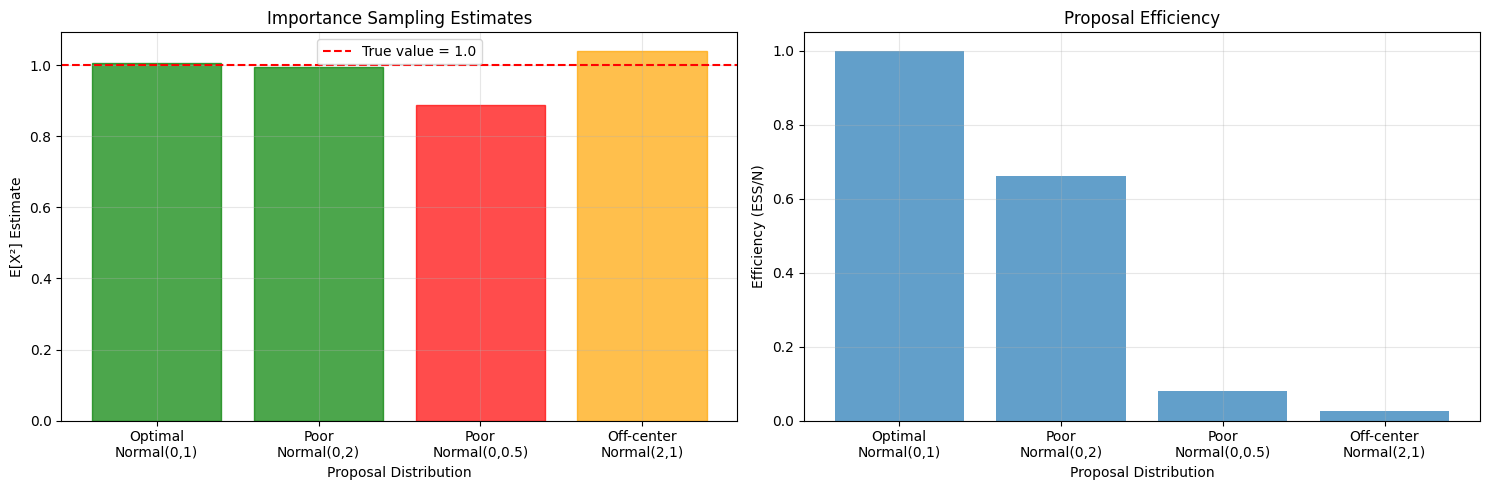


Key Insights:
1. The optimal proposal matches the target distribution
2. Proposals with wrong scale or location lead to poor efficiency
3. Even poor proposals can give accurate estimates, but with high variance


: 

In [ ]:
# Example 3: Computing expectations under a normalized target distribution
print("\n" + "=" * 70)
print("Example 3: Computing E[X²] under standard normal using different proposals")
print("=" * 70)

# Target distribution: standard normal (normalized)
target_normal = stats.norm(loc=0, scale=1)


# Function: f(x) = x² (we want to compute E[X²] = Var(X) + (E[X])² = 1 + 0 = 1)
def squared_function(x):
    return x**2


# Try different proposal distributions
proposals_normal = {
    "Optimal Normal(0,1)": stats.norm(loc=0, scale=1),  # Same as target (optimal)
    "Poor Normal(0,2)": stats.norm(loc=0, scale=2),  # Too broad
    "Poor Normal(0,0.5)": stats.norm(loc=0, scale=0.5),  # Too narrow
    "Off-center Normal(2,1)": stats.norm(loc=2, scale=1),  # Wrong location
}

print(f"Computing E[X²] under N(0,1) using {n_samples:,} samples:")
print("True value: E[X²] = 1.0\n")

normal_results = {}

for name, proposal in proposals_normal.items():
    # For normalized target, use normalized=True
    estimate, diagnostics = importance_sampling(
        f=squared_function,
        target=target_normal,
        proposal=proposal,
        n_samples=n_samples,
        normalized=True,  # Target is normalized
        seed=42,
    )

    normal_results[name] = {"estimate": estimate, "diagnostics": diagnostics}

    # Print results
    error = abs(estimate - 1.0)
    print(f"Proposal: {name}")
    print(f"  E[X²] estimate: {estimate:.6f} (error: {error:.6f})")
    print(
        f"  ESS: {diagnostics['effective_sample_size']:.0f} ({diagnostics['proposal_efficiency']:.1%})"
    )
    print(f"  CV of weights: {diagnostics['cv_weights']:.3f}")
    print(f"  Standard Error: {diagnostics['standard_error']:.4e}")
    print()

# Find best and worst proposals
best_proposal_normal = min(
    normal_results.keys(), key=lambda k: abs(normal_results[k]["estimate"] - 1.0)
)
worst_proposal_normal = max(
    normal_results.keys(), key=lambda k: abs(normal_results[k]["estimate"] - 1.0)
)

print(f"Most accurate: {best_proposal_normal}")
print(f"Least accurate: {worst_proposal_normal}")

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Estimates comparison
names = list(normal_results.keys())
estimates = [normal_results[name]["estimate"] for name in names]
errors = [abs(est - 1.0) for est in estimates]

bars = ax1.bar(range(len(names)), estimates, alpha=0.7)
ax1.axhline(y=1.0, color="red", linestyle="--", label="True value = 1.0")
ax1.set_xlabel("Proposal Distribution")
ax1.set_ylabel("E[X²] Estimate")
ax1.set_title("Importance Sampling Estimates")
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels(
    [name.replace(" ", "\n") for name in names], rotation=0, ha="center"
)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Color bars by accuracy
for i, (bar, error) in enumerate(zip(bars, errors)):
    if error < 0.01:
        bar.set_color("green")
    elif error < 0.05:
        bar.set_color("orange")
    else:
        bar.set_color("red")

# Plot 2: Efficiency comparison
efficiencies = [
    normal_results[name]["diagnostics"]["proposal_efficiency"] for name in names
]
bars2 = ax2.bar(range(len(names)), efficiencies, alpha=0.7)
ax2.set_xlabel("Proposal Distribution")
ax2.set_ylabel("Efficiency (ESS/N)")
ax2.set_title("Proposal Efficiency")
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels(
    [name.replace(" ", "\n") for name in names], rotation=0, ha="center"
)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("1. The optimal proposal matches the target distribution")
print("2. Proposals with wrong scale or location lead to poor efficiency")
print("3. Even poor proposals can give accurate estimates, but with high variance")